In [1]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



In [2]:
symbols = ['BTCUSDT', 'ETHUSDT', 'XLMUSDT',
           'LTCUSDT', 'BNBUSDT', 'XRPUSDT', 'SOLUSDT', 'LUNAUSDT', 'ADAUSDT', 'USDCUSDT']
valueStock = []
for symbol in symbols:
    klinesT = Client().get_historical_klines(
        symbol, Client.KLINE_INTERVAL_1HOUR, "01 January 2017")
    print(f"{symbol} downloaded")
    valueStock.append(klinesT)


BTCUSDT downloaded
ETHUSDT downloaded
XLMUSDT downloaded
LTCUSDT downloaded
BNBUSDT downloaded
XRPUSDT downloaded
SOLUSDT downloaded
LUNAUSDT downloaded
ADAUSDT downloaded
USDCUSDT downloaded


# Create SMA200/600 strategy

SMA200 and SMA600 are some good indicator about the tension of the market, and how it gonna grow. If SMA200 line is above the SMA600 line, it mean that the market got some real chance to grow.

Also, adding the EMA100, witch is a good support line about the market. If the market is above this line, it's mean that the market is growing, same a if it's under, the market gonna crash. 

In [112]:
def createSignal(data):
    """
    Create signal where to buy and where to sell
    Args:
        data (pd DataFrames): All the usefull data to work
    Returns: No return 
    """

    data['SMA200'] = data['close'].rolling(200).mean()
    data['SMA600'] = data['close'].rolling(600).mean()
    data['EMA100'] = data['close'].ewm(span=100, adjust=False).mean()

    buy = []
    sell = []
    i = 0
    flag = -1
    while i < len(data.index):
        while i < 600:
            buy.append(False)
            sell.append(False)
            i += 1
        if data['SMA200'].iloc[i] > data['SMA600'].iloc[i]:
            if flag == 1:
                buy.append(False)
                sell.append(False)
            else:
                buy.append(True)
                sell.append(False)
                flag = 1
        else:
            if flag == 0 or data['SMA200'].iloc[i] > data['SMA600'].iloc[i]:
                buy.append(False)
                sell.append(False)
            else:
                buy.append(False)
                sell.append(True)
                flag = 0

        i += 1

    data['Buy'] = buy
    data['Sell'] = sell


In [94]:
def clearData(data):
    """
    Clear all the useless columns
    Args:
        data (pd DataFrames): All the usefull data to work
    Returns: No return 
    """
    del data['close_time']
    del data['quote_av']
    del data['trades']
    del data['tb_base_av']
    del data['tb_quote_av']
    del data['ignore']

    data['close'] = pd.to_numeric(data['close'])
    data['high'] = pd.to_numeric(data['high'])
    data['low'] = pd.to_numeric(data['low'])
    data['open'] = pd.to_numeric(data['open'])

    data = data.set_index(data['timestamp'])
    data.index = pd.to_datetime(data.index, unit='ms')

    del data['timestamp']

In [95]:
def backTest(data, risk):
    """
    BackTest the strat on the all data
    Args:
        data (pd DataFrames): All the usefull data to work
        risk (float) : Stop lose
    Returns: The total    
    """
    money = 1000
    crypto = 0
    tmpMoney = 0

    for i in range(len(data.index)):
        currentMoney = money + crypto * data['close'].iloc[i]
        if data['Buy'].iloc[i] == True:
            crypto = money/data['close'].iloc[i]
            crypto = crypto - 0.0007 * crypto
            tmpMoney = money
            money = 0
    #Here there is a stop lost, to study
        if (data['Sell'].iloc[i] == True and money == 0) or (money == 0 and currentMoney < tmpMoney * risk):
            money = crypto * data['close'].iloc[i]
            money = money - 0.0007 * money
            crypto = 0
            tmpMoney = 0

    total = money + crypto * data['close'].iloc[-1]
    return total

In [113]:
indexResult = [i for i in np.arange(1.00, 0.80, -0.01)]
results = pd.DataFrame(index = indexResult)
for value in range(len(valueStock)):
    data = pd.DataFrame(valueStock[value], columns=['timestamp', 'open', 'high', 'low', 'close',
                        'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])

    clearData(data)
    createSignal(data)
    
    moneyResult = []
    for i in np.arange(1.00, 0.80, -0.01):
        moneyResult.append(backTest(data, i))
    results[symbols[value]] = moneyResult

In [114]:
print(results)

           BTCUSDT       ETHUSDT      XLMUSDT      LTCUSDT        BNBUSDT  \
1.00   1258.198924    741.966358   920.934460  1053.372576    1288.229857   
0.99   1169.866068   3059.005045   978.227147  1271.292278    2349.761481   
0.98   6126.143619   8614.332316  1710.609103  2250.805370    3179.302311   
0.97   9597.352838   6933.390589  2970.380554  1593.687732   14894.304690   
0.96   8296.390933   7915.919481  2267.160910  1853.970174   77557.251771   
0.95   9963.608079  12756.226554  1692.736395  1461.880725   62532.623906   
0.94  41604.433528  27526.291150  1271.473618  4457.725221   50953.115592   
0.93  41703.115801  26514.856387  1587.867688  5261.543212   43556.083840   
0.92  36810.126857  25637.709603  1356.172778  7966.856976   45547.820169   
0.91  31680.988205  27762.901386  1018.747019  5804.727308   36275.561991   
0.90  31336.173197  26774.356463   993.114616  5274.360788  163642.546389   
0.89  32183.869985  25312.580317  1073.799423  5000.251649  227667.039939   

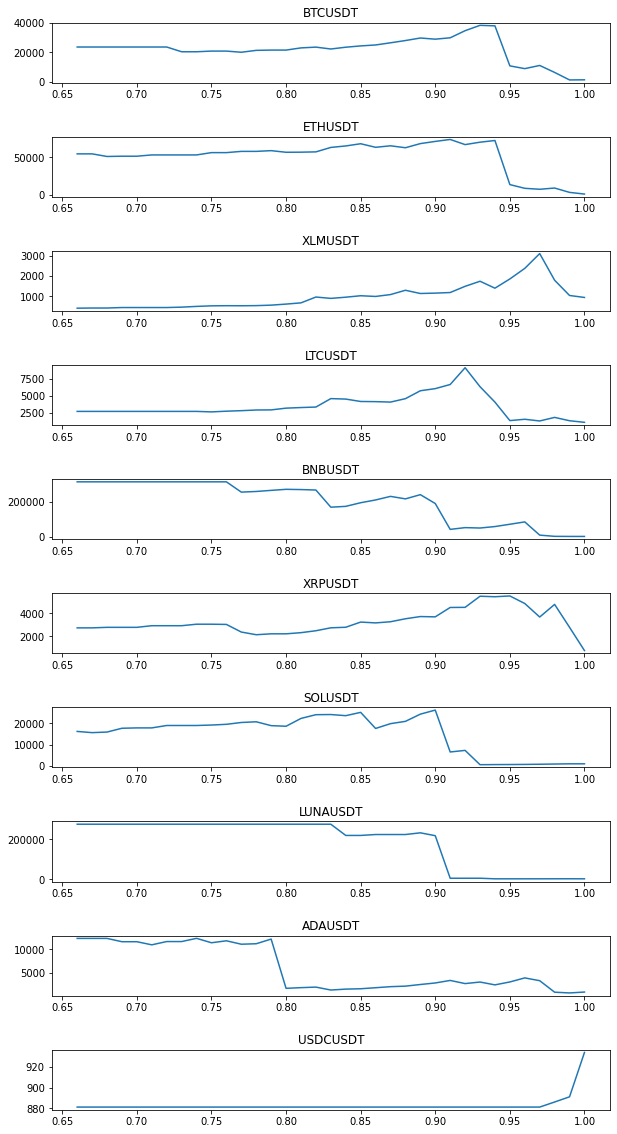

In [9]:
fig, ax = plt.subplots(10, figsize=(10,20))
for i in range(len(symbols)):
    ax[i].plot(results[symbols[i]])
    ax[i].set_title(symbols[i])

plt.subplots_adjust(hspace=0.9)


# MACD Signal

## Create a MACD signal, combnated with the earlier SMA signal.

Trying to get better results, by increasing the details of signals, ceate real signal.
At the end, this get good results, close to the previous strategy, but not as efficient.

In [14]:
data = pd.DataFrame(valueStock[1], columns=['timestamp', 'open', 'high', 'low', 'close',
                                                'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
clearData(data)

In [86]:
def createSignalMACD(data):
    data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['EMA200'] = data['close'].ewm(span=200, adjust=False).mean()
    data['SMA200'] = data['close'].rolling(200).mean()
    data['SMA600'] = data['close'].rolling(600).mean()

    data['signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    del data['EMA12']
    del data['EMA26']

    buy = []
    sell = []
    i = 0
    flag = -1
    while i < len(data.index):
        while i < 100:
            buy.append(False)
            sell.append(False)
            i += 1
        if data['MACD'].iloc[i] > data['signal'].iloc[i] and data['MACD'].iloc[i] > 0 and data['close'].iloc[i] > data['EMA200'].iloc[i] and data['SMA200'].iloc[i] > data['SMA600'].iloc[i]:
            if flag == 1:
                buy.append(False)
                sell.append(False)
            else:
                buy.append(True)
                sell.append(False)
                flag = 1
        else:
            if flag == 0 or (data['MACD'].iloc[i] > data['signal'].iloc[i] or data['SMA200'].iloc[i] > data['SMA600'].iloc[i]) or data['close'].iloc[i] > data['EMA200'].iloc[i]:
                buy.append(False)
                sell.append(False)
            else:
                buy.append(False)
                sell.append(True)
                flag = 0

        i += 1

    data['Buy'] = buy
    data['Sell'] = sell




In [87]:
indexResult = [i for i in np.arange(1.00, 0.60, -0.01)]
results = pd.DataFrame(index=indexResult)
for value in range(len(valueStock)):
    data = pd.DataFrame(valueStock[value], columns=['timestamp', 'open', 'high', 'low', 'close',
                        'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])

    clearData(data)
    createSignalMACD(data)

    moneyResult = []
    for i in np.arange(1.00, 0.60, -0.01):
        moneyResult.append(backTest(data, i))
    results[symbols[value]] = moneyResult


In [88]:
print(results)

           BTCUSDT       ETHUSDT      XLMUSDT       LTCUSDT        BNBUSDT  \
1.00    954.001054    854.734167   889.250646   1125.390875    1001.043931   
0.99    951.053211    969.148543   860.686131   1329.593631    1470.313313   
0.98   8144.657567   1155.602965  1432.490312   1998.042308    9648.287308   
0.97   9664.580724   2166.089498  1989.737653   1619.473387   10067.948785   
0.96   8581.426348   2749.550196  1527.035869   1617.379907  101305.646410   
0.95  10481.317609   6720.017942  1578.301334   1647.174815   83636.557236   
0.94  34243.003546  23255.421434  1254.858476   5368.119673   59940.188514   
0.93  29554.994571  21806.376192  1544.750646   6624.719423   53302.828272   
0.92  28130.200401  65053.863652  1328.780686  10010.283790   51761.709826   
0.91  23527.683879  68786.946803  1073.036317  10171.814142   43390.139925   
0.90  24788.069392  62809.107641   936.747543   9414.519303  194104.258683   
0.89  24444.729923  57131.732976   813.003688   9161.672481  252

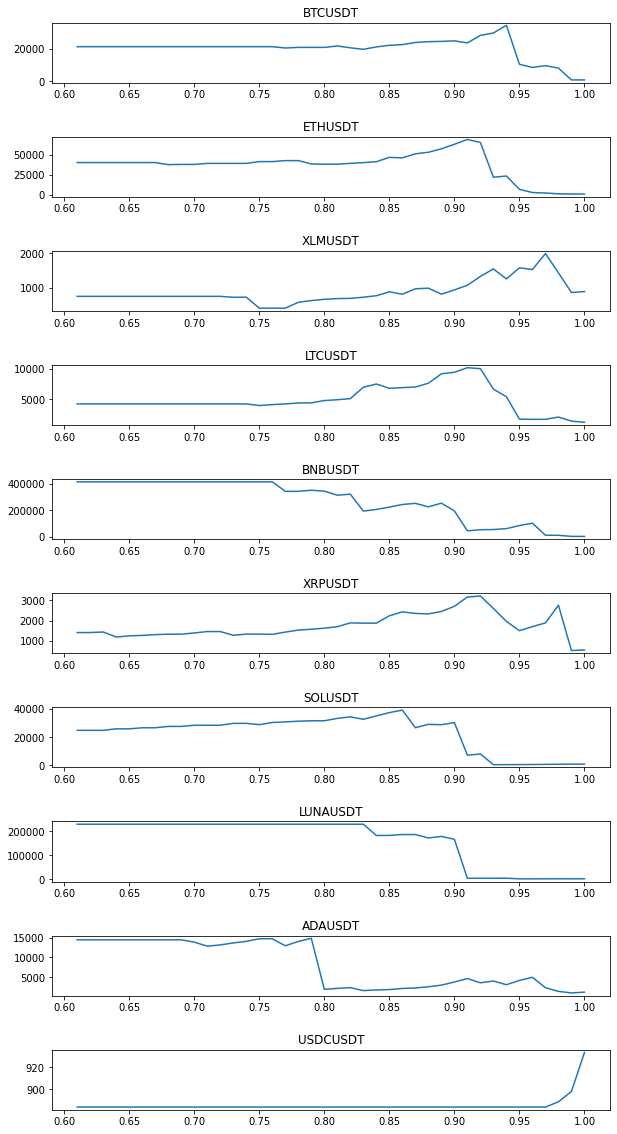

In [89]:
fig, ax = plt.subplots(10, figsize=(10, 20))
for i in range(len(symbols)):
    ax[i].plot(results[symbols[i]])
    ax[i].set_title(symbols[i])

plt.subplots_adjust(hspace=0.9)

# Conclusion about these backtestings

## General

These trainding strategies are really efficient when the market is aways growing, as crypto. If the market is flat, or deacresing, these strategy will not work as much as here. It's because, I do not inverst when the market getting down, and also need more indicator, and more sophisticated one, to get the better result.


At the end, this was also to manipulate pandas, and matplotlib module, create some fun things around it. Also, I could discover the finnancial analyses.

## SMA200 / SMA600

This is a good strategy, if the market get up, but there is a lot of losing trade, and also a lot of winning trade. Meanning, we need to keep safe controle, and think about the investissement.
But it's vey efficient ! 

Also, need to adjust the risk on certain crypto to get the better result (about 0.94-0.90 on BTC and ETH, and less on youger crypto)

## MACD

This is a good strat, with few trade over 5 years (about 30 on BTC) so needed to be patient. But this is not a really good strategy, and need to be use a 100%, cause here, I do not use the difference between the two lines (MACD and Signal). Also, it could be cool to use it with an other complexe strat.